In [1]:
import os
import numpy as np

import pandas as pd
# Set maximum number of rows and columns shown
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns
# Define custom colors/cmaps/palettes for visualization purposes.
denim='#6F8FAF'
salmon='#FA8072'
slate_gray = '#404040'
cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",[denim,salmon])
palette = 'colorblind'
sns.set_style('darkgrid')

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, recall_score, make_scorer, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from light_famd import FAMD
import prince

import warnings
# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
DATA_PATH = './archive'

df = pd.read_csv(os.path.join(DATA_PATH, 'Base.csv'))

target = 'fraud_bool'

X = df.drop(target,axis=1)
y = df[target]

# Train/test split with stratified sampling

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1).copy()
train_copy = pd.concat([X_train, y_train], axis=1).copy()

feature_descriptions = {
    'income' : "Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].",
    'name_email_similarity' : "Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].",
    'prev_address_months_count' : "Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).",
    'current_address_months_count' : "Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).",
    'customer_age' : "Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.",
    'days_since_request' : "Number of days passed since application was done. Ranges between [0, 79] days.",
    'intended_balcon_amount' : "Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).",
    'payment_type': "Credit payment plan type. 5 possible (annonymized) values.",
    'zip_count_4w' : "Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].",
    'velocity_6h' : "Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].",
    'velocity_24h' : "Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].",
    'velocity_4w' : "Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].",
    'bank_branch_count_8w' : "Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].",
    'date_of_birth_distinct_emails_4w' : "Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].",
    'employment_status' : "Employment status of the applicant. 7 possible (annonymized) values.",
    'credit_risk_score' : "Internal score of application risk. Ranges between [−191, 389].",
    'email_is_free' : "Domain of application email (either free or paid).",
    'housing_status' : "Current residential status for applicant. 7 possible (annonymized) values.",
    'phone_home_valid' : "Validity of provided home phone.",
    'phone_mobile_valid' : "Validity of provided mobile phone.",
    'bank_months_count' : "How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).",
    'has_other_cards' : "If applicant has other cards from the same banking company.",
    'proposed_credit_limit' : "Applicant’s proposed credit limit. Ranges between [200, 2000].",
    'foreign_request' : "If origin country of request is different from bank’s country.",
    'source' : "Online source of application. Either browser (INTERNET) or app (TELEAPP).",
    'session_length_in_minutes' : "Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).",
    'device_os' : "Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.",
    'keep_alive_session' : "User option on session logout.",
    'device_distinct_emails_8w' : "Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).",
    'device_fraud_count' : "Number of fraudulent applications with used device. Ranges between [0, 1].",
    'month' : "Month where the application was made. Ranges between [0, 7].",
    'fraud_bool' : "If the application is fraudulent or not."
}

num_feats = X_train.select_dtypes(include='number').columns.tolist()

thresh = 25

cont_feats = [feat for feat in num_feats if df[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_feats if df[feat].nunique() < thresh]

In [ ]:
# Dealing with missing values
cols_missing_neg1 = ['prev_address_months_count',
                     'current_address_months_count',
                     'bank_months_count',
                     'session_length_in_minutes',
                     'device_distinct_emails_8w']

X_train[cols_missing_neg1] = X_train[cols_missing_neg1].replace(-1,np.nan)

col_missing_neg = 'intended_balcon_amount'

X_train[col_missing_neg] = X_train[col_missing_neg]\
    .apply(lambda x: np.nan if x < 0 else x)

# # Missing values by feature

# null_X_train = X_train.isna().sum()/len(X_train)*100

In [10]:
preserved_rows = X_train.dropna().index
y_train = y_train.loc[preserved_rows]
X_train = X_train.dropna()

In [11]:
first_X = X_train
first_Y = y_train
first_X = first_X.reset_index(drop=True)
first_Y = first_Y.reset_index(drop=True)

In [20]:
sum(y_train)

69

In [12]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(first_X[cont_feats].to_numpy())

pca = PCA(n_components=4)

principal_components = pca.fit_transform(data_scaled)

print("Principal components:")
print(principal_components)

print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

Principal components:
[[ 0.55009185 -0.25559797  1.74255638 -0.03421526]
 [-0.03303803 -0.87955891 -0.18505665 -0.5612682 ]
 [-1.7459633  -2.28609128 -0.69545254  0.45609358]
 ...
 [ 2.10921545  0.1824925  -1.35800499  0.00783268]
 [-0.61968693 -0.416095   -0.22322998 -0.79107273]
 [ 0.48100381  0.58678037 -0.05795939 -0.25922276]]
Explained variance ratio:
[0.14666181 0.08958857 0.08602208 0.07506603]


In [13]:
famd = prince.FAMD(
    n_components=2,
    n_iter=100,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(first_X)

/home/minny/anaconda3/envs/lng/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.3913383183301076, -0.888742707654474, -0.9533117391738998, -0.5560963462010655, -0.4470496340037238, -0.4579853109211933, -0.49233509092998873, -0.4785645002103825, -0.48844025377118655, -0.4942710004537287, -0.5026313565945024, -0.49707340987393045, -0.5120431439580826, -0.4974226009320116, -0.48433489105158073, -0.4718045169851629, -0.4334427191919594, -0.41018518484242916, -0.37130289302067127, -0.341333836350667, -0.2993249596707139, -0.2764040613659338, -0.24966939342180935, -0.2243970177370246, -0.2236218961886329, -0.20876367941045043, -0.2120644956094081, -0.21732141988500134, -0.2141016652988709, -0.21772054128622884, -0.21000756536943038, -0.20285805392217857, -0.20667390027604418, -0.20959375695678575, -0.21328913232858093, -0.2079302881417676, -0.20371219687432643, -0.19321343065148022, -0.19411001751168125, -0.192312

In [14]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,21.425,0.03%,0.03%
1,20.432,0.03%,0.06%


In [15]:
famd.column_coordinates_

component,0,1
variable,,
income,2.668870e-05,2.026609e-02
name_email_similarity,3.872336e-05,1.899338e-03
prev_address_months_count,1.888052e-05,5.109140e-03
current_address_months_count,2.108980e-05,4.302959e-03
days_since_request,4.114257e-07,4.841777e-03
intended_balcon_amount,3.706557e-06,1.180083e-03
velocity_6h,3.989153e-05,1.856788e-02
velocity_24h,5.530081e-05,3.854550e-02
velocity_4w,7.116915e-05,8.080076e-02


In [16]:
principal_components = famd.fit_transform(first_X)

/home/minny/anaconda3/envs/lng/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.3913383183301076, -0.888742707654474, -0.9533117391738998, -0.5560963462010655, -0.4470496340037238, -0.4579853109211933, -0.49233509092998873, -0.4785645002103825, -0.48844025377118655, -0.4942710004537287, -0.5026313565945024, -0.49707340987393045, -0.5120431439580826, -0.4974226009320116, -0.48433489105158073, -0.4718045169851629, -0.4334427191919594, -0.41018518484242916, -0.37130289302067127, -0.341333836350667, -0.2993249596707139, -0.2764040613659338, -0.24966939342180935, -0.2243970177370246, -0.2236218961886329, -0.20876367941045043, -0.2120644956094081, -0.21732141988500134, -0.2141016652988709, -0.21772054128622884, -0.21000756536943038, -0.20285805392217857, -0.20667390027604418, -0.20959375695678575, -0.21328913232858093, -0.2079302881417676, -0.20371219687432643, -0.19321343065148022, -0.19411001751168125, -0.192312

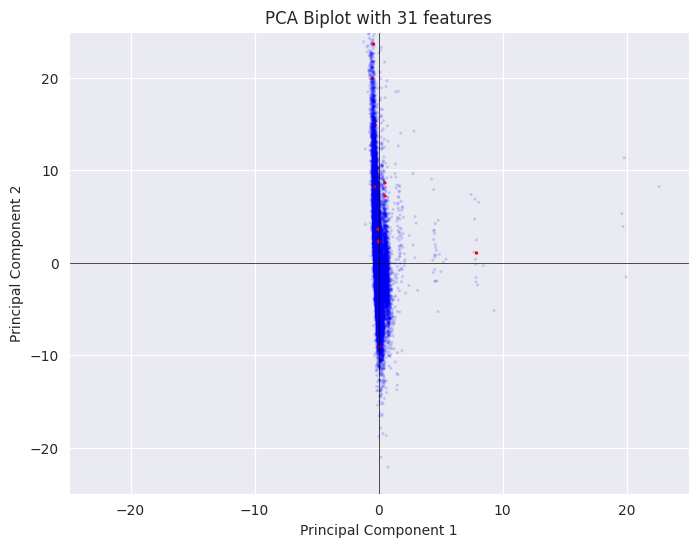

In [17]:
principal_components_np = principal_components.to_numpy()
# Plot the principal components with colors based on categories
plt.figure(figsize=(8, 6))
colors = ['blue' if x == 0 else 'red' for x in first_Y]
alphas = [0.1 if x == 0 else 1.0 for x in first_Y]
plt.scatter(principal_components_np[:, 0], principal_components_np[:, 1], color=colors, alpha=alphas,s=2)

# Plot the loadings.
# for i, (comp1, comp2) in enumerate(loadings):
#     plt.arrow(0, 0, comp1*3, comp2*3, color='b', alpha=0.5)
#     plt.text(comp1*3.2, comp2*3.2, f"Var{i+1}", color='g', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with 31 features')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.show()

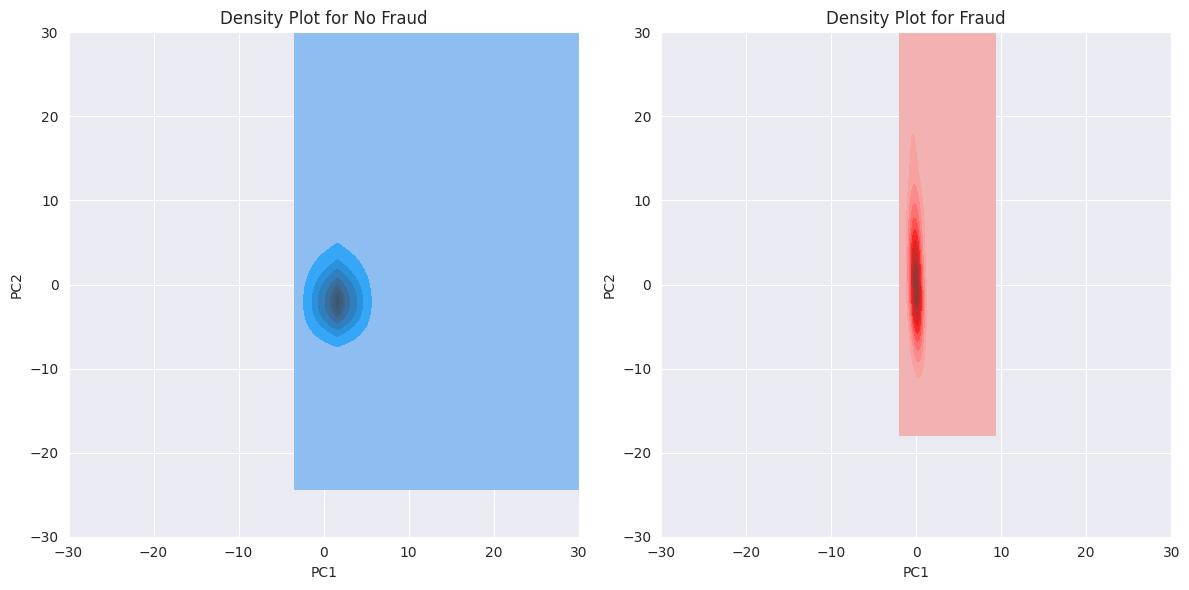

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot KDE for the first dataset
sns.kdeplot(data=principal_components.loc[first_Y == 0], x=0, y=1, fill=True, thresh=0,
           ax=axes[0])
axes[0].set_title('Density Plot for No Fraud')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_xlim(-30, 30)  # Adjust the range as needed
axes[0].set_ylim(-30, 30)  # Adjust the range as needed

# Plot KDE for the second dataset
sns.kdeplot(data=principal_components.loc[first_Y == 1], x=0, y=1, fill=True, thresh=0,
           ax=axes[1], color='red')
axes[1].set_title('Density Plot for Fraud')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_xlim(-30, 30)  # Adjust the range as needed
axes[1].set_ylim(-30, 30)  # Adjust the range as needed

# Display the plot
plt.tight_layout()
# plt.savefig("kdeplot.png")
plt.show()

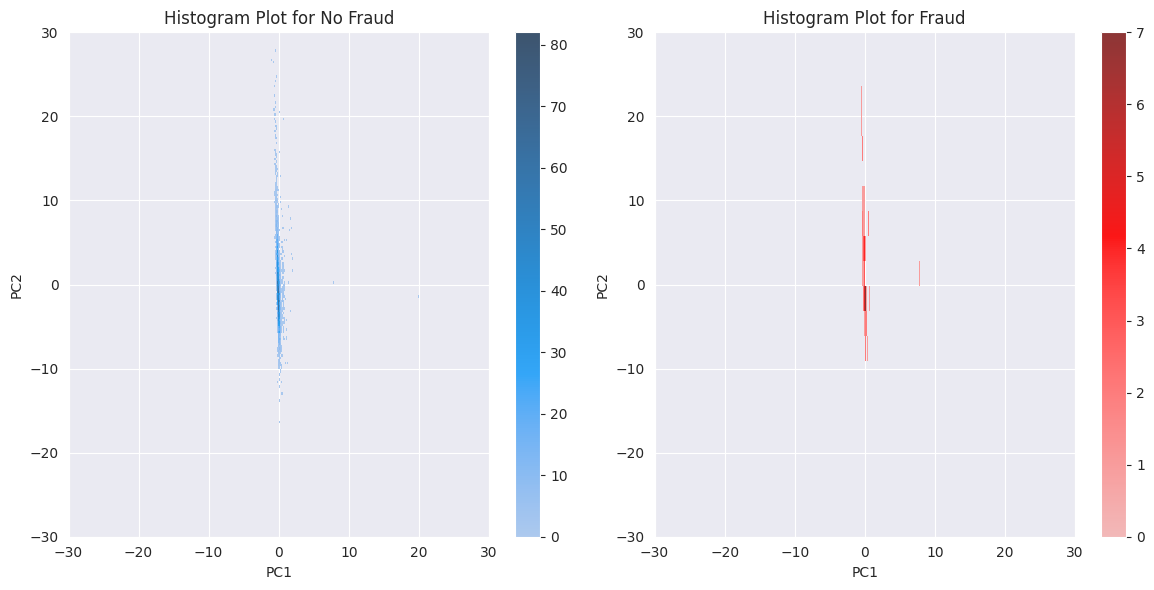

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot KDE for the first dataset
sns.histplot(data=principal_components.loc[first_Y == 0], x=0, y=1, cbar=True,
           ax=axes[0])
axes[0].set_title('Histogram Plot for No Fraud')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_xlim(-30, 30)  # Adjust the range as needed
axes[0].set_ylim(-30, 30)  # Adjust the range as needed
# Plot KDE for the second dataset
sns.histplot(data=principal_components.loc[first_Y == 1], x=0, y=1, cbar=True,
           ax=axes[1], color='red')
axes[1].set_title('Histogram Plot for Fraud')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_xlim(-30, 30)  # Adjust the range as needed
axes[1].set_ylim(-30, 30)  # Adjust the range as needed

# Display the plot
plt.tight_layout()
# plt.savefig("hist.png")
plt.show()